In [6]:
import os
import torch
import clip
import numpy as np
import pandas as pd
import pyarrow.feather as feather
from PIL import Image
from urllib import request
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision
from torch.nn.utils.rnn import pad_sequence

In [4]:
!pip install open_clip_torch

  Using cached open_clip_torch-2.20.0-py3-none-any.whl (1.5 MB)
  Using cached ftfy-6.1.1-py3-none-any.whl (53 kB)


In [5]:
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Retrieving notices: ...working... done

# >>>>>>>>>>>>>>>>>>>>>> ERROR REPORT <<<<<<<<<<<<<<<<<<<<<<

    Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/conda/gateways/repodata/__init__.py", line 161, in conda_http_errors
        yield
      File "/opt/conda/lib/python3.10/site-packages/conda/gateways/repodata/__init__.py", line 127, in repodata
        response.raise_for_status()
      File "/opt/conda/lib/python3.10/site-packages/requests/models.py", line 1021, in raise_for_status
        raise HTTPError(http_error_msg, response=self)
    requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://conda.anaconda.org/rapidsai/linux-64/current_repodata.json
    
    During handling of the above exception, another exception occurred:
    
    Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/requests/models.py", line 971, in json
        return complexjson.loads(self.text, **kwargs)
      File "

In [7]:
import open_clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.cuda()
device

'cuda'

In [8]:
# Download the dataset
cifar100 = datasets.CIFAR100(root=os.path.expanduser("~/.cache"), download = True, train = True)

100%|██████████| 169001437/169001437 [00:09<00:00, 17356559.15it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [9]:
cifar100_data = cifar100.data
cifar100_targets = cifar100.targets

In [10]:
for i in zip(np.unique(cifar100_targets), cifar100.classes):
    print(i[0], ':', i[1])

0 : apple
1 : aquarium_fish
2 : baby
3 : bear
4 : beaver
5 : bed
6 : bee
7 : beetle
8 : bicycle
9 : bottle
10 : bowl
11 : boy
12 : bridge
13 : bus
14 : butterfly
15 : camel
16 : can
17 : castle
18 : caterpillar
19 : cattle
20 : chair
21 : chimpanzee
22 : clock
23 : cloud
24 : cockroach
25 : couch
26 : crab
27 : crocodile
28 : cup
29 : dinosaur
30 : dolphin
31 : elephant
32 : flatfish
33 : forest
34 : fox
35 : girl
36 : hamster
37 : house
38 : kangaroo
39 : keyboard
40 : lamp
41 : lawn_mower
42 : leopard
43 : lion
44 : lizard
45 : lobster
46 : man
47 : maple_tree
48 : motorcycle
49 : mountain
50 : mouse
51 : mushroom
52 : oak_tree
53 : orange
54 : orchid
55 : otter
56 : palm_tree
57 : pear
58 : pickup_truck
59 : pine_tree
60 : plain
61 : plate
62 : poppy
63 : porcupine
64 : possum
65 : rabbit
66 : raccoon
67 : ray
68 : road
69 : rocket
70 : rose
71 : sea
72 : seal
73 : shark
74 : shrew
75 : skunk
76 : skyscraper
77 : snail
78 : snake
79 : spider
80 : squirrel
81 : streetcar
82 : sunflow

In [ ]:
EPOCH = 3
for i in range(EPOCH):
    print('NOW EPOCH :', i)
    

In [ ]:
total_correct = 0
import cv2
hist =[]
for i in range(0, 50000):
    if i%100==0:
        print('PROGRESS :', ((i+1)/50000) * 100.0)
        print('NUM_CORRECT :',total_correct)
    image, class_id = cifar100[i]
    image = np.array(image)
    image =cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    image = Image.fromarray(image)
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_inputs = torch.cat([open_clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)
    
    #Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image_input).to(device)
        text_features = model.encode_text(text_inputs).to(device)
    
    
    
    # Pick the top 1 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(1)
    
    
    if indices[0] == cifar100_targets[i]:
        total_correct += 1
    
    hist.append([(((i+1)/50000) * 100.0),total_correct])
print(total_correct)
    

PROGRESS : 0.002
NUM_CORRECT : 0
PROGRESS : 0.202
NUM_CORRECT : 81
PROGRESS : 0.402
NUM_CORRECT : 155
PROGRESS : 0.602
NUM_CORRECT : 238
PROGRESS : 0.8019999999999999
NUM_CORRECT : 319
PROGRESS : 1.002
NUM_CORRECT : 388
PROGRESS : 1.202
NUM_CORRECT : 463
PROGRESS : 1.402
NUM_CORRECT : 534
PROGRESS : 1.6019999999999999
NUM_CORRECT : 604
PROGRESS : 1.802
NUM_CORRECT : 679
PROGRESS : 2.002
NUM_CORRECT : 759
PROGRESS : 2.202
NUM_CORRECT : 830
PROGRESS : 2.402
NUM_CORRECT : 903
PROGRESS : 2.6020000000000003
NUM_CORRECT : 974
PROGRESS : 2.802
NUM_CORRECT : 1046
PROGRESS : 3.0020000000000002
NUM_CORRECT : 1127
PROGRESS : 3.202
NUM_CORRECT : 1205
PROGRESS : 3.402
NUM_CORRECT : 1285
PROGRESS : 3.6020000000000003
NUM_CORRECT : 1358
PROGRESS : 3.8019999999999996
NUM_CORRECT : 1437
PROGRESS : 4.002
NUM_CORRECT : 1512
PROGRESS : 4.202
NUM_CORRECT : 1595
PROGRESS : 4.401999999999999
NUM_CORRECT : 1675
PROGRESS : 4.601999999999999
NUM_CORRECT : 1755
PROGRESS : 4.802
NUM_CORRECT : 1841
PROGRESS : 5.00

In [20]:
accuracy = (100.0) * total_correct / 50000
print(f"분류 정확도: {accuracy:.2f}%")

분류 정확도: 75.78%


In [21]:
type(cifar100[0][0])

PIL.Image.Image

In [23]:
import matplotlib.pyplot as plt

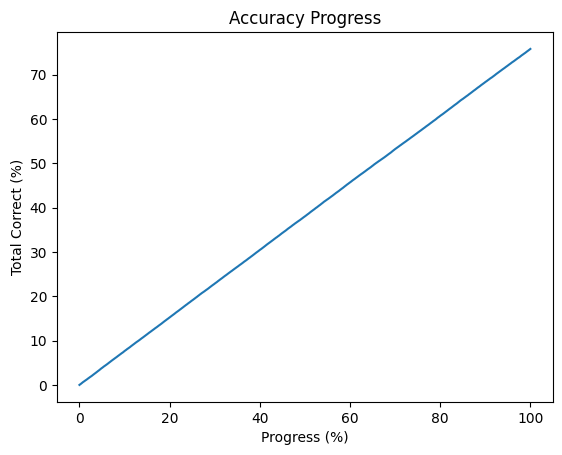

In [26]:
x = [entry[0] for entry in hist]
y = [entry[1]/50000*100 for entry in hist]

plt.plot(x, y)
plt.xlabel('Progress (%)')
plt.ylabel('Total Correct (%)')
plt.title('Accuracy Progress')
plt.show()